In [90]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [91]:
import glob

def calibrateCamera():
    imgpoints = []
    objpoints = []

    objp = np.zeros((9*6, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    images = glob.glob("./camera_cal/calibration*.jpg")

    for fname in images:
        img = mpimg.imread(fname)

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        ret,corners = cv2.findChessboardCorners(gray, (9, 6), None)
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)

    return cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

def undistortImage(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

ret, mtx, dist, rvecs, tvecs = calibrateCamera()

In [294]:
class BinarizeImage:
    def sobel(self, img, axis='x', sobel_kernel=3, thresh=(0,255)):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        if axis == 'x':
            sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        else:
            sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
            
        abs_sobel = np.absolute(sobel)

        scaled = np.uint8(abs_sobel*255/np.max(abs_sobel))

        mask = np.zeros_like(scaled)
        mask[(scaled>=thresh[0]) & (scaled<=thresh[1])] = 1

        return mask

    def hlsMask(self, img, thresh=(0, 255)):
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        S = hls[:,:, 2]

        mask = np.zeros_like(S)
        mask[(S>thresh[0]) & (S<=thresh[1])] = 1
        
        return mask

    def sobel_mag(self, img, sobel_kernel=3, thresh=(0,255)):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
        sobel_mag = (sobelx**2 + sobely**2)**0.5
        abs_sobel = np.absolute(sobel_mag)

        scaled = np.uint8(abs_sobel*255/np.max(abs_sobel))

        mask = np.zeros_like(scaled)
        mask[(scaled>=thresh[0]) & (scaled<=thresh[1])] = 1
        
        return mask
    
    def sobelDir(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

        gradient = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

        mask = np.zeros_like(gray)
        mask[(gradient>=thresh[0]) & (gradient<=thresh[1])] = 1

        return mask
    
    def sobelHLS(self, img, display_output=False):
        img = cv2.GaussianBlur(img, (5,5), 0)
        
        sobelx = self.sobel(img, 'x', 5, thresh=(30, 70))
        hlsbinary = self.hlsMask(img, (120, 180))
        
        sobel_mag = self.sobel_mag(img, 7, thresh=(20, 225))
        sobel_dir = self.sobelDir(img, 7, thresh=(0.1,1.2))
        
        sobel_mag_dir = np.zeros_like(sobel_dir)
        sobel_mag_dir[(sobel_mag==1)&(sobel_dir==1)] = 1
        
        yellow_mask = cv2.inRange(img, np.array([120, 120, 0]), np.array([255, 255, 120]))
        yellow_binary = (yellow_mask // 255).astype(np.uint8)

        white_mask = cv2.inRange(img, np.array([165, 165, 165]), np.array([255, 255, 255]))
        white_binary = (white_mask // 255).astype(np.uint8)

        combined = np.zeros_like(sobelx)
        combined[(sobel_mag_dir==1)&((hlsbinary==1) | (yellow_binary==1) | (white_binary==1)) | (yellow_binary==1)]=1

        if display_output:
            f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,20))
            ax1.set_title('Sobel X')
            ax1.imshow(sobelx, cmap='gray')

            ax2.set_title('S channel')
            ax2.imshow(hlsbinary, cmap='gray')
            
            ax3.set_title('Magnitude')
            ax3.imshow(sobel_mag, cmap='gray')

            ax4.set_title('Direction')
            ax4.imshow(sobel_dir, cmap='gray')
            
            ax5.set_title('Mag_dir')
            ax5.imshow(sobel_mag_dir, cmap='gray')
            
            ax6.set_title('Yellow')
            ax6.imshow(yellow_binary, cmap='gray')
            
            ax7.set_title('White')
            ax7.imshow(white_binary, cmap='gray')
            
            ax8.set_title('Combined')
            ax8.imshow(combined, cmap='gray')
            
            plt.show()
            
        return combined
    

In [295]:
class Line:
    def __init__(self):
        
        # was the line detected in the last iteration?
        self.detected = False
        
        # x values of the last n fits of the line
        self.recent_fits = []
        self.recent_fits_meter = []
        
        #polynomial coefficients for the most recent fit
        self.last_fit = None
        self.last_fit_meter = None
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        
        self.ym_per_pix = 30 / 720   # meters per pixel in y dimension
        self.xm_per_pix = 3.7 / 700  
        
        self.buffer = 10
        
    def update(self, new_fit, new_fit_m, detected):
        self.detected = detected
        self.last_fit = new_fit
        self.last_fit_meter = new_fit_m
        
        self.recent_fits.extend([new_fit.tolist()])
        self.recent_fits_meter.extend([new_fit_m])
        
    def getRadiusOfCurvature(self):
        y_eval = 0
        last_fit_meter = np.mean(self.recent_fits_meter[-self.buffer*2: ], axis=0)
        roc = ((1+(2*last_fit_meter[0]*y_eval*self.ym_per_pix + last_fit_meter[1])**2)**1.5)/np.absolute(2*last_fit_meter[0])
        return roc
           
    def get_line_from_prev_fit(self, img_birdeye, line_left, line_right, display_output=False):
        margin = 100
        
        nonzero = img_birdeye.nonzero()
        nonzero_y = nonzero[0]
        nonzero_x = nonzero[1]
        
        coeff_l = line_left.last_fit
        coeff_r = line_right.last_fit
        left_include = ((nonzero_x>(coeff_l[0]*nonzero_y**2+coeff_l[1]*nonzero_y+coeff_l[2] - margin)) &
            (nonzero_x<(coeff_l[0]*nonzero_y**2+coeff_l[1]*nonzero_y+coeff_l[2] + margin)))
        right_include = ((nonzero_x>(coeff_r[0]*nonzero_y**2+coeff_r[1]*nonzero_y+coeff_r[2] - margin)) & 
            (nonzero_x<(coeff_r[0]*nonzero_y**2+coeff_r[1]*nonzero_y+coeff_r[2] + margin) ))
        
        leftx = nonzero_x[left_include]
        lefty = nonzero_y[left_include]
        rightx = nonzero_x[right_include]
        righty = nonzero_y[right_include]
        
        detected = False
        if len(leftx)>0 and len(lefty)>0:
            left_fit = np.polyfit(lefty, leftx, 2)
            left_fit_m = np.polyfit(lefty * self.ym_per_pix, leftx * self.xm_per_pix, 2)
            detected = True
        else:
            left_fit = line_left.last_fit
            left_fit_m = line_left.last_fit_meter
        line_left.update(left_fit, left_fit_m, detected)
        
        detected = False
        if len(rightx)>0 and len(righty)>0:
            right_fit = np.polyfit(righty, rightx, 2)
            right_fit_m = np.polyfit(righty * self.ym_per_pix, rightx * self.xm_per_pix, 2)
            detected = True
        else:
            right_fit = line_right.last_fit
            right_fit_m = line_right.last_fit_meter
    
        line_right.update(right_fit, right_fit_m, detected)
        
        ploty = np.linspace(0,img_birdeye.shape[0]-1, img_birdeye.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img = np.dstack((img_birdeye, img_birdeye, img_birdeye))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])

        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

        if display_output:
            # Plot the polynomial lines onto the image
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            
            plt.imshow(result)
            plt.show()

        return result
        
    def get_line_sliding_window(self, img_birdeye, prev_line_left, prev_line_right, n_windows=9, display_output=False):
        h, w = img_birdeye.shape

        histogram = np.sum(img_birdeye[h//2:], axis=0)

        mid = w//2

        left_x_init = np.argmax(histogram[:mid])
        right_x_init = np.argmax(histogram[mid:]) + mid

        window_height = h//n_windows

        margin = 100
        minpix = 50

        nonzero = img_birdeye.nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])

        left_x_curr = left_x_init
        right_x_curr = right_x_init

        left_lane_inds = []
        right_lane_inds = []

        out_img = np.dstack((img_birdeye,img_birdeye,img_birdeye))*255

        for i in range(n_windows):
            left_x_min = left_x_curr - margin
            left_x_max = left_x_curr + margin
            right_x_min = right_x_curr - margin
            right_x_max = right_x_curr + margin
            win_y_high = h - i * margin
            win_y_low = h - (i+1)*margin

            cv2.rectangle(out_img, (left_x_min, win_y_low), (left_x_max, win_y_high), (0, 255, 0), 2)
            cv2.rectangle(out_img, (right_x_min, win_y_low), (right_x_max, win_y_high), (0, 255, 0), 2)

            left_inds_include =  ((nonzero_y>=win_y_low) & (nonzero_y<win_y_high) & 
                                  (nonzero_x>=left_x_min)  & (nonzero_x<left_x_max )).nonzero()[0]
            right_inds_include = ((nonzero_y>=win_y_low) & (nonzero_y<win_y_high) & 
                                  (nonzero_x>=right_x_min) & (nonzero_x<right_x_max)).nonzero()[0]

            left_lane_inds.extend(left_inds_include)
            right_lane_inds.extend(right_inds_include)

            if len(left_inds_include)>=minpix:
                left_x_curr = np.int(np.mean(nonzero_x[left_inds_include]))
            if len(right_inds_include)>=minpix:
                right_x_curr = np.int(np.mean(nonzero_x[right_inds_include]))

        leftx, lefty = nonzero_x[left_lane_inds], nonzero_y[left_lane_inds]
        rightx, righty = nonzero_x[right_lane_inds], nonzero_y[right_lane_inds]

        detected = False
        if len(leftx)>0 and len(lefty)>0:
            left_fit = np.polyfit(lefty, leftx, 2)
            left_fit_m = np.polyfit(lefty * self.ym_per_pix, leftx * self.xm_per_pix, 2)
            detected = True
        else:
            left_fit = prev_line_left.last_fit
            left_fit_m = prev_line_left.last_fit_meter
            
        prev_line_left.update(left_fit, left_fit_m, detected)
        
        detected = False
        if len(rightx)>0 and len(righty)>0:
            right_fit = np.polyfit(righty, rightx, 2)
            right_fit_m = np.polyfit(righty * self.ym_per_pix, rightx * self.xm_per_pix, 2)
            detected = True
        else:
            right_fit = prev_line_right.last_fit
            right_fit_m = prev_line_right.last_fit_meter
    
        prev_line_right.update(right_fit, right_fit_m, detected)
        
        
        ploty = np.linspace(0,img_birdeye.shape[0]-1, img_birdeye.shape[0])
        left_line = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_line = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        out_img[lefty, leftx] = [255,0,0]
        out_img[righty, rightx] = [0,0, 255]

        if display_output:
            print("ROC: ", prev_line_left.getRadiusOfCurvature(), prev_line_right.getRadiusOfCurvature())
            plt.plot(left_line, ploty, color='yellow')
            plt.plot(right_line, ploty, color='yellow')

            plt.imshow(out_img)
            plt.show()
        
        return out_img
            
    def draw_region_on_road(self, img_birdeye, undistorted, line_left, line_right, Minv, display_output=False):
        h, w = img_birdeye.shape
        
        left_fit = np.mean(line_left.recent_fits[-self.buffer:], axis=0)
        right_fit = np.mean(line_right.recent_fits[-self.buffer:], axis=0)
       
        #print("last fit left: ", line_left.last_fit)
        #print("mean fit left: ", left_fit)
        #print("last fit right: ", line_right.last_fit)
        #print("mean fit right: ", right_fit)
        
        ploty = np.linspace(0, h-1, h)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        warp_zero = np.zeros_like(img_birdeye)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
        
        warped_original_shape = cv2.warpPerspective(color_warp, Minv, (w,h))
        
        result = cv2.addWeighted(undistorted, 1, warped_original_shape, 0.3, 0)
        
        if display_output:
            plt.imshow(result)
            plt.show()
            
        return result

In [313]:
class Pipeline:
    def __init__(self, mtx, dist):
        self.mtx = mtx
        self.dist = dist
        self.line_left, self.line_right = Line(), Line()
        
        self.frame_no = 0
        self.roc_list = []
        self.roc = 0

        self.line_left, self.line_right = Line(), Line()
        
        self.ym_per_pix = 30 / 720   # meters per pixel in y dimension
        self.xm_per_pix = 3.7 / 700  
    
    def undistortImage(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

    def getWarpedImage(self, img, display_output=False):
        h, w = img.shape[:2]
        src = np.float32([
            [w, h-20],
            [0, h-20],
            [546, 460],
            [732, 460]
        ])

        dst = np.float32([
            [w, h],
            [0, h],
            [0, 0],
            [w, 0]
        ])

        M = cv2.getPerspectiveTransform(src, dst)
        Minv = cv2.getPerspectiveTransform(dst, src)

        warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)

        if display_output:
            plt.imshow(warped, cmap='gray')
            plt.show()
            
        return warped, M, Minv
      
    def get_offset_from_center(self, img, line_left, line_right, display_output=False):
        h,w = img.shape
        
        if line_left.detected and line_right.detected:
            coeff_l = line_left.last_fit
            coeff_r = line_right.last_fit

            x_left = coeff_l[0]*h**2+coeff_l[1]*h+coeff_l[2]
            x_right = coeff_r[0]*h**2+coeff_r[1]*h+coeff_r[2]

            lane_width = x_right-x_left
            camera_pos = w/2

            lane_center = x_left+lane_width/2
            offset = (lane_center - camera_pos)*self.xm_per_pix
        else:
            offset = -1
            
        return offset
    
    def draw_text(self, img, text, x, y):
        cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_DUPLEX, 0.8, (255, 255, 255), 2, cv2.LINE_AA)

    def drawUI(self, img, img_binary, img_top, lines_drawn):
        h, w, _ = img.shape
        off_x, off_y = 20, 40
        
        overlay = img.copy()
        cv2.rectangle(overlay, (0,0), (w,220), (0,0,0), -1)
        cv2.addWeighted(img, 0.7, overlay,0.3,0, img)
        
        thumbnail_ratio = 0.2
        thumb_h, thumb_w = np.int(thumbnail_ratio * h), np.int(thumbnail_ratio*w)
        
        thumb_binary = cv2.resize(img_binary, dsize=(thumb_w, thumb_h))
        thumb_binary = np.dstack([thumb_binary, thumb_binary, thumb_binary])*255
        
        thumb_top = cv2.resize(img_top, dsize=(thumb_w, thumb_h))
        thumb_top = np.dstack([thumb_top, thumb_top, thumb_top])*255
        
        lines_drawn = cv2.resize(lines_drawn, dsize=(thumb_w, thumb_h))
        
        img[off_y:thumb_h+off_y, off_x:off_x+thumb_w, :] = thumb_binary
        img[off_y:thumb_h+off_y, 2*off_x+thumb_w:2*(off_x+thumb_w), :] = thumb_top
        img[off_y:thumb_h+off_y, 3*off_x+2*thumb_w:3*(off_x+thumb_w), :] = lines_drawn

        self.draw_text(img, "Radius Of Curvature: {:0.1f}m".format(self.roc), 860, off_y+60)
        self.draw_text(img, "Offset from Center: {:0.1f}m".format(self.offset), 860, off_y+100)
    
    def process(self, img, display_output=False, isRGB=True):

        if not isRGB:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        undistorted = self.undistortImage(img)
        img_binary = BinarizeImage().sobelHLS(undistorted, display_output=display_output)
        top_down, M, Minv = self.getWarpedImage(img_binary, display_output=display_output)

        if self.frame_no == 0 or self.line_left.detected == False or self.line_right.detected == False or ((self.roc-(self.line_left.getRadiusOfCurvature()+self.line_right.getRadiusOfCurvature())/2)*100/self.roc)>10:
            lines_drawn = Line().get_line_sliding_window(top_down, self.line_left, self.line_right, display_output=display_output)
        else:
            lines_drawn = Line().get_line_from_prev_fit(top_down, self.line_left, self.line_right, display_output=display_output)
        
        result_road = Line().draw_region_on_road(top_down, undistorted, self.line_left, self.line_right, Minv, display_output=display_output)

        roc_curr = (self.line_left.getRadiusOfCurvature()+self.line_right.getRadiusOfCurvature())/2

        self.roc_list.extend([roc_curr])

        self.roc = np.mean(self.roc_list[-20:])
        self.offset = self.get_offset_from_center(top_down, self.line_left, self.line_right)
    
        self.drawUI(result_road, img_binary, top_down, lines_drawn)
        
        self.frame_no+=1
        
        return result_road
    

In [314]:
saveline = Pipeline(mtx, dist)
ud = saveline.undistortImage(img)
ib = BinarizeImage().sobelHLS(ud)
mpimg.imsave('output_images/binary_img.jpg', np.dstack((ib,ib,ib))*255)

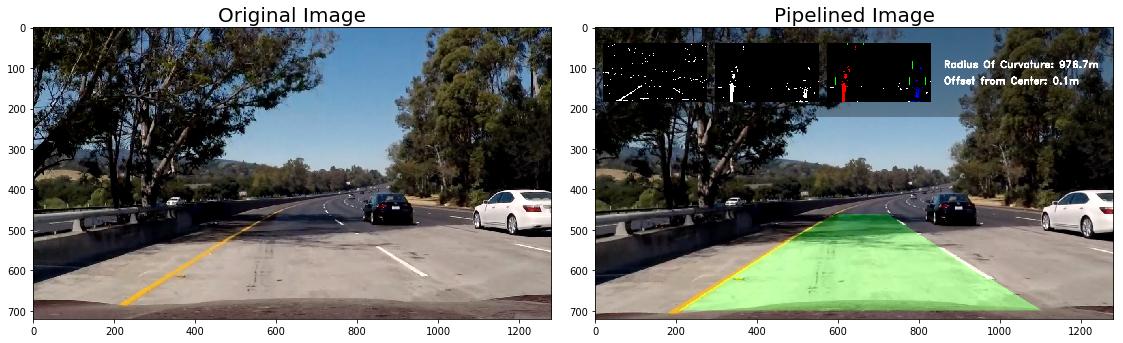

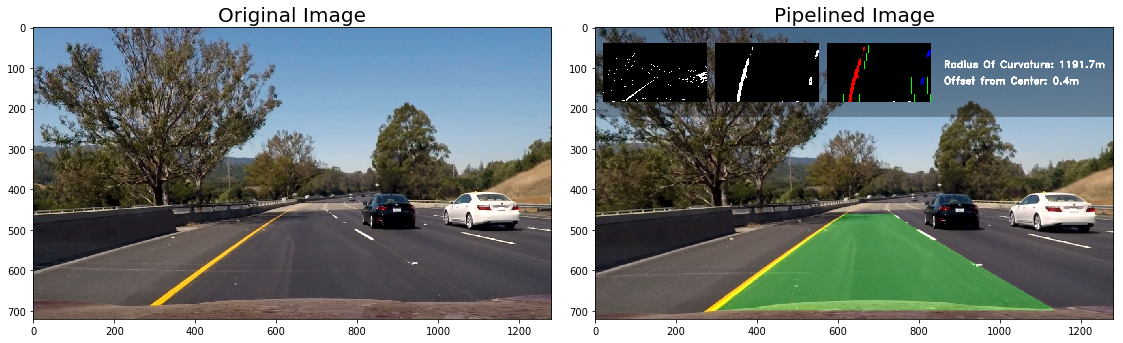

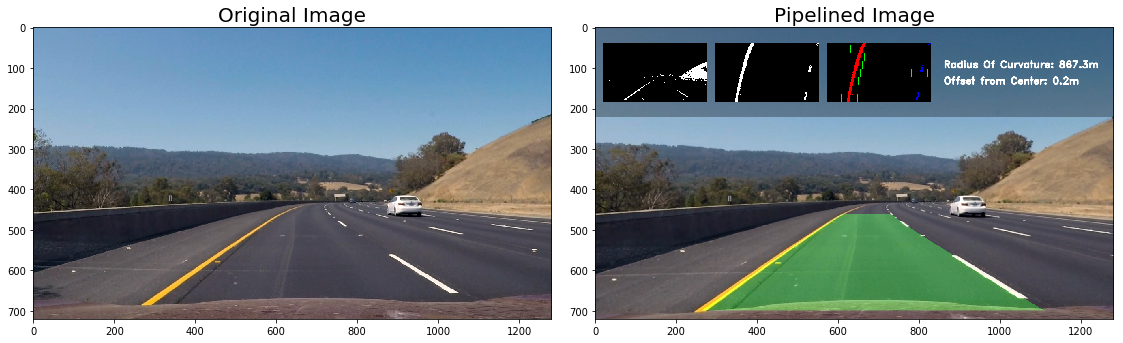

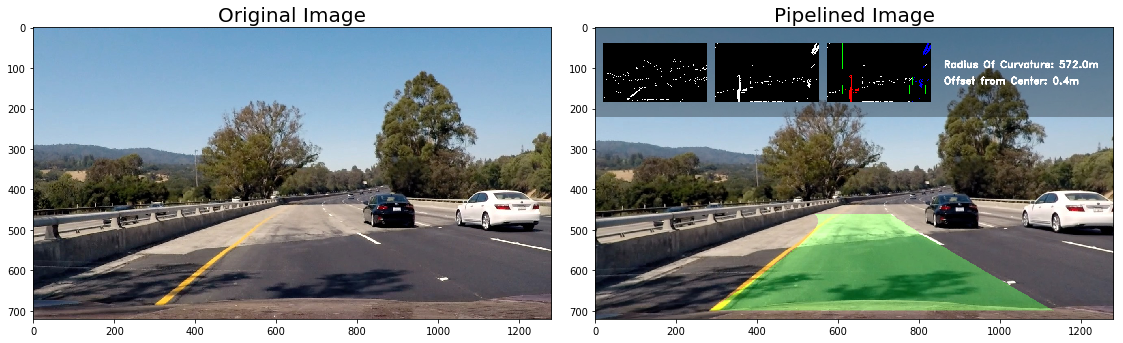

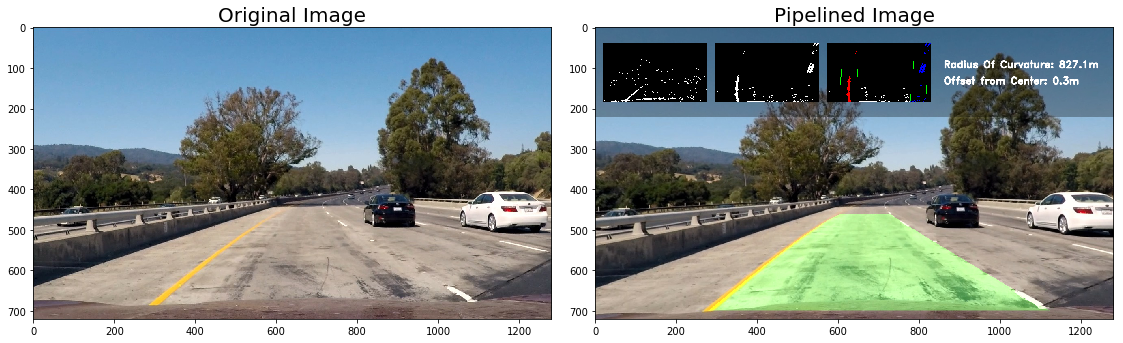

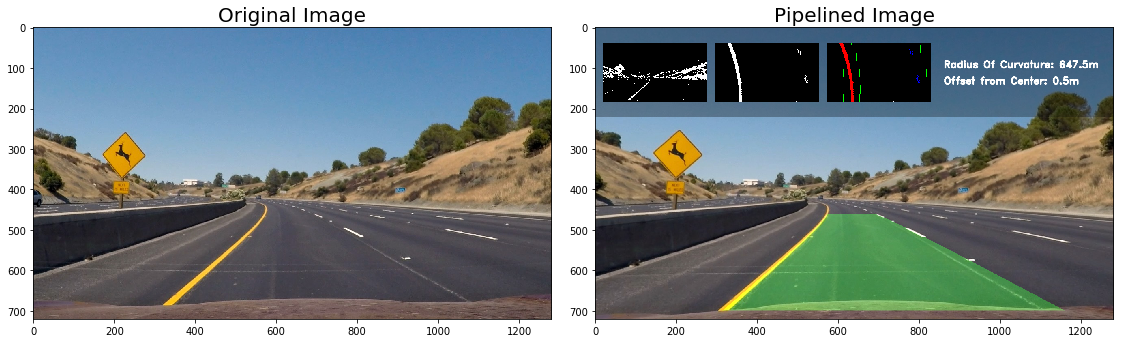

In [319]:
images = glob.glob("./test_images/test*.jpg")

for fname in images:
    img = mpimg.imread(fname)
    
    pipeline = Pipeline(mtx, dist)
    out = pipeline.process(img)
    
    mpimg.imsave(fname.replace('test_images', 'output_images'), out)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(out, cmap='gray')
    ax2.set_title('Pipelined Image', fontsize=20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

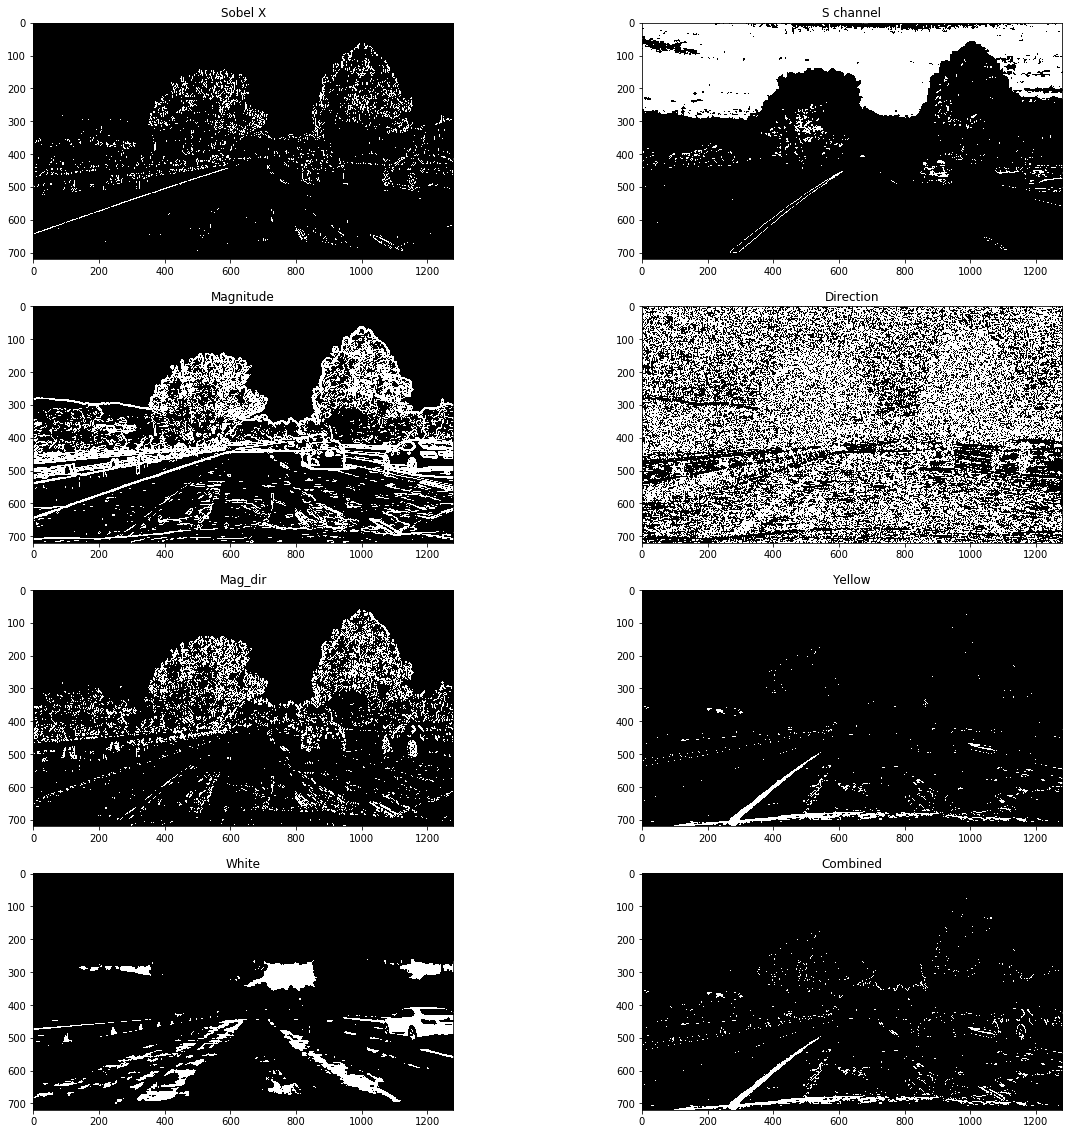

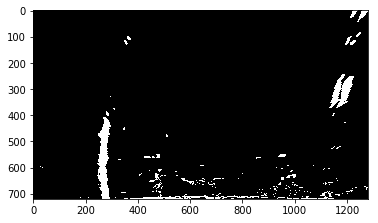

ROC:  365.725705045 1288.56336002


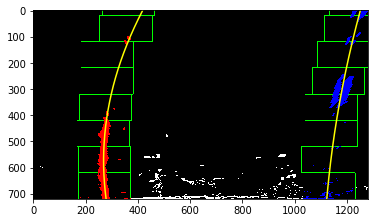

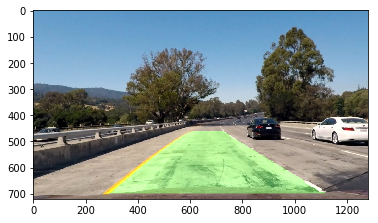

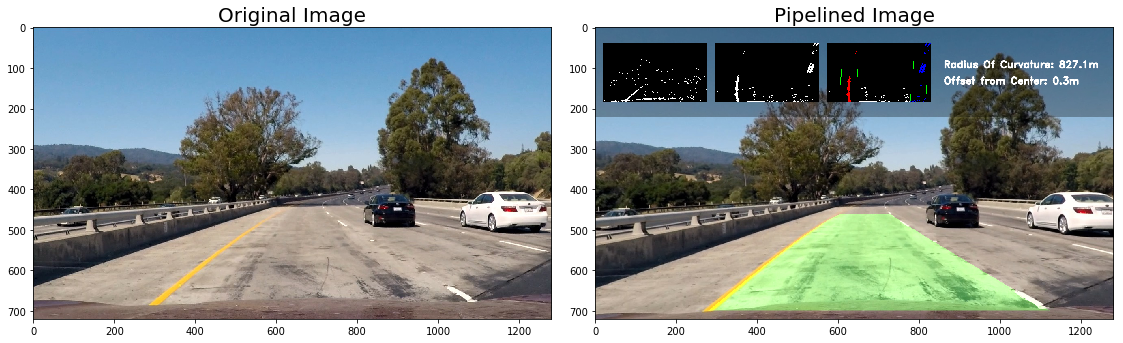

In [315]:
img = mpimg.imread("./test_images/test1.jpg")
# img = frames[90]
pipeline = Pipeline(mtx, dist)
out = pipeline.process(img, True,True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(out, cmap='gray')
ax2.set_title('Pipelined Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [316]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def build_video(video_path):
    pipeline = Pipeline(mtx, dist)
    
    clip = VideoFileClip(video_path+".mp4")
    output = clip.fl_image(pipeline.process) #NOTE: this function expects color images!!
    %time output.write_videofile(video_path+"_edited.mp4", audio=False)

In [317]:
build_video('project_video')

[MoviePy] >>>> Building video project_video_edited.mp4
[MoviePy] Writing video project_video_edited.mp4



100%|█████████▉| 1260/1261 [07:13<00:00,  3.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_edited.mp4 

CPU times: user 4min 19s, sys: 45.2 s, total: 5min 5s
Wall time: 7min 16s


In [318]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_video_edited.mp4'))

In [302]:
build_video('challenge_video')

[MoviePy] >>>> Building video challenge_video_edited.mp4
[MoviePy] Writing video challenge_video_edited.mp4



 32%|███▏      | 155/485 [00:51<01:56,  2.84it/s]


 64%|██████▎   | 309/485 [01:45<01:01,  2.88it/s]


 95%|█████████▌| 463/485 [02:40<00:07,  2.78it/s]


100%|██████████| 485/485 [02:47<00:00,  2.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_edited.mp4 

CPU times: user 1min 40s, sys: 24.5 s, total: 2min 4s
Wall time: 2min 50s


In [303]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('challenge_video_edited.mp4'))

In [249]:
challenge_output = 'harder_challenge_video.mp4'
vidObj = cv2.VideoCapture(challenge_output)
frames = []

while(True): 
      
    # reading from frame 
    ret,frame = vidObj.read() 
  
    if ret: 
        frames += [frame]
    else: 
        break
        
print(len(frames))

1199


In [304]:
build_video('harder_challenge_video')

[MoviePy] >>>> Building video harder_challenge_video_edited.mp4
[MoviePy] Writing video harder_challenge_video_edited.mp4



 13%|█▎        | 152/1200 [01:05<06:49,  2.56it/s]


 25%|██▌       | 303/1200 [02:08<06:02,  2.47it/s]


 38%|███▊      | 454/1200 [03:11<05:05,  2.44it/s]


 50%|█████     | 605/1200 [04:10<03:37,  2.74it/s]


 63%|██████▎   | 756/1200 [05:13<03:03,  2.42it/s]


 76%|███████▌  | 907/1200 [06:17<01:52,  2.59it/s]


 88%|████████▊ | 1057/1200 [07:15<00:52,  2.73it/s]


100%|█████████▉| 1199/1200 [08:12<00:00,  2.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_edited.mp4 

CPU times: user 4min 18s, sys: 1min 4s, total: 5min 22s
Wall time: 8min 16s


In [312]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('harder_challenge_video_edited.mp4'))